In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [23]:
# Load data
cars = pd.read_csv("../data/cardekho.csv", encoding='cp1251')
cars = cars.drop('seller_type', axis=1).dropna()
cars.sample(5)

,name,year,selling_price,km_driven,fuel,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
6645,BMW 3 Series 320d Highline,2012,1100000,80000,Diesel,Automatic,Second Owner,16.07,1995.0,181,5.0
6040,Maruti Alto K10 VXI,2014,220000,100000,Petrol,Manual,First Owner,23.95,998.0,67.05,5.0
5188,BMW 5 Series 520d Luxury Line,2016,3200000,40000,Diesel,Automatic,First Owner,18.12,1995.0,190,5.0
4589,Toyota Innova Crysta 2.4 ZX MT BSIV,2017,1680000,157000,Diesel,Manual,First Owner,13.68,2393.0,147.8,7.0
4127,Hyundai Creta 1.6 CRDi Anniversary Edition,2015,1300000,40000,Diesel,Manual,First Owner,19.67,1582.0,126.2,5.0


In [24]:
#extract brand and model from the name
cars['brand'] = cars['name'].str.split().str[0]
cars['model'] = cars['name'].str.split().str[1]
pd.unique(cars['year'])

array([2014, 2006, 2010, 2007, 2017, 2001, 2011, 2013, 2005, 2009, 2016,
       2012, 2002, 2015, 2018, 2019, 2008, 2020, 1999, 2000, 2003, 2004,
       1994, 1998, 1997, 1995, 1996])

In [25]:
#one hot encode small categorical data
cars = pd.get_dummies(cars, columns=['brand', 'fuel', 'transmission', 'owner'])  # usually not too many brands
model_avg_price = cars.groupby('model')['selling_price'].mean()
cars['model_encoded'] = cars['model'].map(model_avg_price)
cars.drop(['name', 'model', 'mileage(km/ltr/kg)'], axis=1, inplace=True)

In [26]:
# Create car_age and interaction feature (e.g., km driven per year)
cars['car_age'] = 2025 - cars['year']
cars['car_age'] = cars['car_age'].clip(upper=20)  # Cap age to 20 years max
cars['km_per_year'] = cars['km_driven'] / cars['car_age']
cars.drop('year', axis=1, inplace=True)

In [27]:
#removing data that is affecting accuracy (outlier)
cars = cars[(cars['selling_price'] > 100000) & (cars['selling_price'] < 1000000)]
cars = cars[(cars['km_driven'] < 500000) & (cars['engine'] < 5000)]
cars.sample(3)

,selling_price,km_driven,engine,max_power,seats,brand_Ambassador,brand_Ashok,brand_Audi,brand_BMW,brand_Chevrolet,...,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,model_encoded,car_age,km_per_year
6713,200000,200000,2489.0,95,8.0,False,False,False,False,False,...,False,True,False,False,False,False,True,335254.843137,14,14285.714286
5541,125000,50000,1061.0,67,5.0,False,False,False,False,False,...,False,True,False,False,True,False,False,261877.092199,16,3125.000000
983,180000,120000,1248.0,75,5.0,False,False,False,False,False,...,False,True,False,False,True,False,False,153019.827338,14,8571.428571


In [28]:
# Prepare features and target
X = cars.drop('selling_price', axis=1)
y = cars['selling_price']

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
#define models
models = {
    "RandomForest (100 trees)": RandomForestRegressor(n_estimators=100, max_depth=11, random_state=42),
    "RandomForest (300 trees)": RandomForestRegressor(n_estimators=300, max_depth=11, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42),
    "LinearRegression": LinearRegression()
}

RandomForest (100 trees): RMSE = 71262.63, Relative RMSE = 15.65%
RandomForest (300 trees): RMSE = 71062.29, Relative RMSE = 15.61%
GradientBoosting: RMSE = 71680.25, Relative RMSE = 15.74%
LinearRegression: RMSE = 90175.97, Relative RMSE = 19.81%

Best model: RandomForest (300 trees) with RMSE = 71062.29
Saved best model to 'car_price_model.pkl'


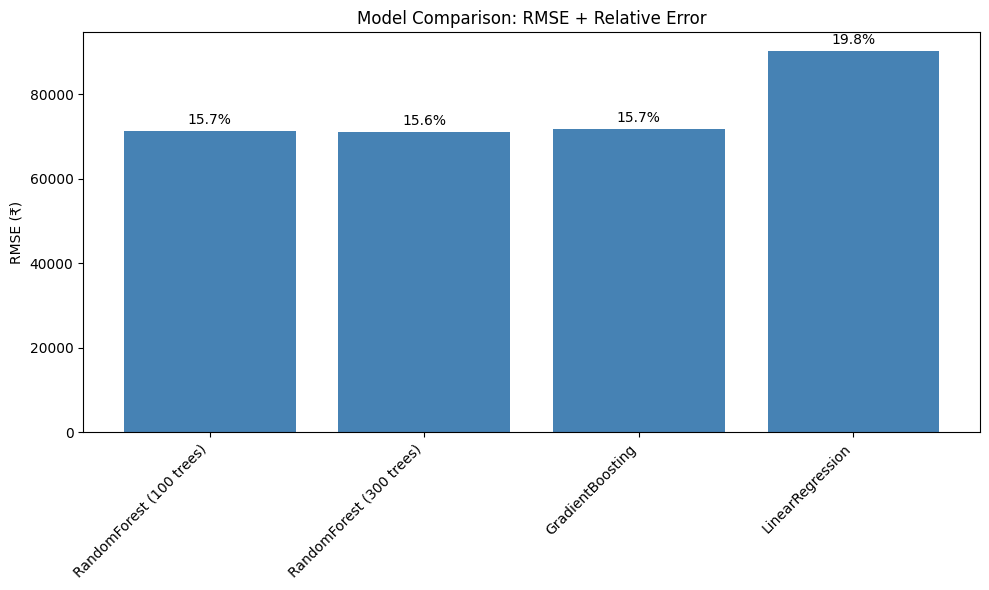

In [31]:
results = {}
mean_price = y_test.mean()
best_rmse = float('inf')
best_model_name = None
best_model = None

# %%
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    relative_rmse = rmse / mean_price * 100  # %

    results[name] = {
        "rmse": rmse,
        "relative_rmse": relative_rmse
    }

    print(f"{name}: RMSE = {rmse:.2f}, Relative RMSE = {relative_rmse:.2f}%")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_model = model

print(f"\nBest model: {best_model_name} with RMSE = {best_rmse:.2f}")

# Save the best model
joblib.dump(best_model, "../src/car_price_model.pkl")
print(f"Saved best model to 'car_price_model.pkl'")

# %%
# Plotting RMSE + relative error %
labels = list(results.keys())
rmse_values = [v["rmse"] for v in results.values()]
relative_errors = [v["relative_rmse"] for v in results.values()]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, rmse_values, color='steelblue')

for bar, pct in zip(bars, relative_errors):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1000, f"{pct:.1f}%", ha='center', va='bottom', fontsize=10)

plt.ylabel("RMSE (₹)")
plt.title("Model Comparison: RMSE + Relative Error")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()